In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# **8:1:1**

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv("ETH.csv")
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
1,2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2,2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
3,2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
4,2019-03-05,127.792953,138.229981,126.735298,137.822388,137.822388,4764849990
...,...,...,...,...,...,...,...
1899,2024-05-12,2911.658203,2953.047363,2902.201904,2928.701904,2928.701904,5908941395
1900,2024-05-13,2928.813965,2994.869141,2865.134521,2949.359619,2949.359619,13352264795
1901,2024-05-14,2949.213135,2959.546631,2863.545898,2881.157959,2881.157959,12444516140
1902,2024-05-15,2881.224609,3041.602295,2864.735352,3037.056641,3037.056641,14666902956


In [3]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1523, 1)
Test shape: (190, 1)
Validate shape: (191, 1)


In [5]:
# 5. Convert an array of values into a dataset matrix
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
23/23 [==============================] - 2s 32ms/step - loss: 0.0070 - val_loss: 3.0148e-04
Epoch 2/100
23/23 [==============================] - 1s 26ms/step - loss: 0.0017 - val_loss: 2.0742e-04
Epoch 3/100
23/23 [==============================] - 1s 37ms/step - loss: 0.0014 - val_loss: 2.1288e-04
Epoch 4/100
23/23 [==============================] - 1s 38ms/step - loss: 0.0012 - val_loss: 4.7917e-04
Epoch 5/100
23/23 [==============================] - 1s 38ms/step - loss: 0.0012 - val_loss: 5.3862e-04
Epoch 6/100
23/23 [==============================] - 1s 28ms/step - loss: 0.0011 - val_loss: 1.3099e-04
Epoch 7/100
23/23 [==============================] - 0s 19ms/step - loss: 0.0010 - val_loss: 1.3845e-04
Epoch 8/100
23/23 [==============================] - 0s 22ms/step - loss: 8.8864e-04 - val_loss: 1.1560e-04
Epoch 9/100
23/23 [==============================] - 0s 20ms/step - loss: 8.7494e-04 - val_loss: 3.8133e-04
Epoch 10/100
23/23 [==============================] - 0s

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)


3/3 [==============================] - 0s 8ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1) )
yval = scaler.inverse_transform(yval.reshape(-1,1) )

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 118.49910650803989
Testing RMSE: 41.43467507007438


In [14]:
# 13. Đánh giá độ chính xác thuật toán MAPE
valid_mape = np.mean(np.abs((y_pred_val - yval) / yval)) * 100
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 2.6925096978455505
Testing MAPE: 1.963791333575371


In [15]:
# 14. Đánh giá độ chính xác thuật toán MAE
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 89.35597060086793
Testing MAE: 32.6930877559691


In [16]:
# 15. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=130
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.47270777 0.47521643 0.52568486 0.53366439 0.51342419 0.52451382
 0.50231726 0.51063859 0.52687334 0.51425567 0.50120646 0.50598788
 0.50175317 0.49841889 0.46798451 0.45306573 0.45155041 0.4481788
 0.45870516 0.45885113 0.45658009 0.46931128 0.4751455  0.46196897
 0.46649526 0.46739144 0.4648391  0.46345822 0.46544542 0.48103901
 0.4920022  0.49118573 0.50556612 0.50848278 0.50983178 0.54185262
 0.53846419 0.56733105 0.57721657 0.57281636 0.56919648 0.588834
 0.60256939 0.6174432  0.60826562 0.60840427 0.59790777 0.61295149
 0.63854157 0.65264274 0.66657997 0.69660977 0.68729693 0.70710649
 0.70434052 0.7190048  0.74866357 0.73261135 0.78881953 0.80054378
 0.80431139 0.8092796  0.8019998  0.84140269 0.82307402 0.8286433
 0.80241398 0.77095152 0.72578276 0.75121155 0.72474585 0.6480962
 0.72376913 0.71942968 0.68554606 0.68616416 0.71127167 0.74025132
 0.73953263 0.72094495 0.73395759 0.72343159 0.72261019 0.75236934
 0.72199032 0.67353848 0.68081434 0.68477024 0.68239753

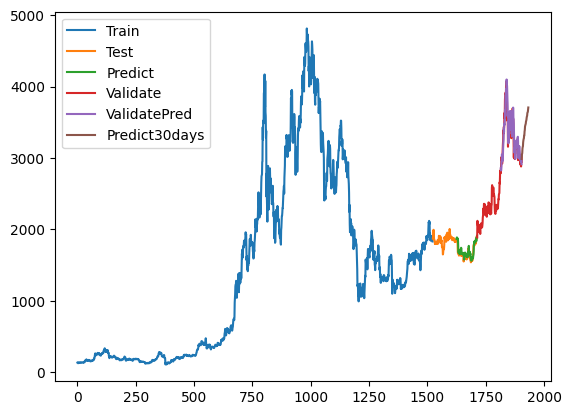

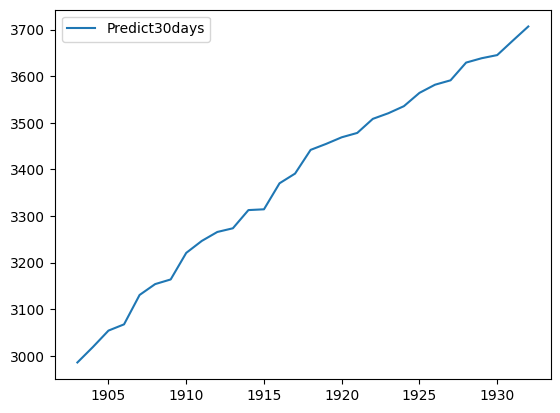

In [17]:
# 16.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()


# Dự đoán 30 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict30days'])
plt.show()

In [18]:
# 17. Dự báo 60 ngày tiếp theo
x_input=val_data[90:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.4920022  0.49118573 0.50556612 0.50848278 0.50983178 0.54185262
 0.53846419 0.56733105 0.57721657 0.57281636 0.56919648 0.588834
 0.60256939 0.6174432  0.60826562 0.60840427 0.59790777 0.61295149
 0.63854157 0.65264274 0.66657997 0.69660977 0.68729693 0.70710649
 0.70434052 0.7190048  0.74866357 0.73261135 0.78881953 0.80054378
 0.80431139 0.8092796  0.8019998  0.84140269 0.82307402 0.8286433
 0.80241398 0.77095152 0.72578276 0.75121155 0.72474585 0.6480962
 0.72376913 0.71942968 0.68554606 0.68616416 0.71127167 0.74025132
 0.73953263 0.72094495 0.73395759 0.72343159 0.72261019 0.75236934
 0.72199032 0.67353848 0.68081434 0.68477024 0.68239753 0.6899055
 0.7110288  0.76245899 0.72201867 0.73022326 0.72203664 0.66626424
 0.61561329 0.64795235 0.63618127 0.63263341 0.61132255 0.62861498
 0.62717947 0.64809812 0.6458991  0.65746217 0.66134595 0.64430739
 0.64786039 0.64225689 0.66820689 0.67046287 0.66039249 0.61718439
 0.60814422 0.61205443 0.63659425 0.63957936 0.6437637 

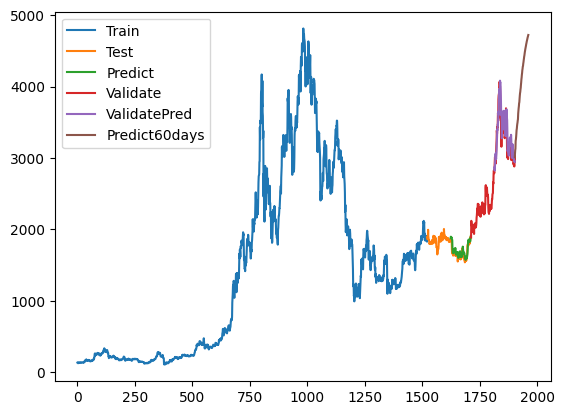

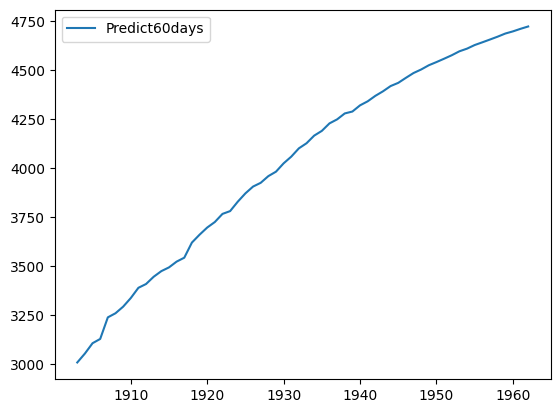

In [ ]:
# 18.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict60days'])
plt.show()


# Dự đoán 60 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict60days'])
plt.show()

In [19]:
# 19. Dự báo 90 ngày tiếp theo
x_input=val_data[90:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.4920022  0.49118573 0.50556612 0.50848278 0.50983178 0.54185262
 0.53846419 0.56733105 0.57721657 0.57281636 0.56919648 0.588834
 0.60256939 0.6174432  0.60826562 0.60840427 0.59790777 0.61295149
 0.63854157 0.65264274 0.66657997 0.69660977 0.68729693 0.70710649
 0.70434052 0.7190048  0.74866357 0.73261135 0.78881953 0.80054378
 0.80431139 0.8092796  0.8019998  0.84140269 0.82307402 0.8286433
 0.80241398 0.77095152 0.72578276 0.75121155 0.72474585 0.6480962
 0.72376913 0.71942968 0.68554606 0.68616416 0.71127167 0.74025132
 0.73953263 0.72094495 0.73395759 0.72343159 0.72261019 0.75236934
 0.72199032 0.67353848 0.68081434 0.68477024 0.68239753 0.6899055
 0.7110288  0.76245899 0.72201867 0.73022326 0.72203664 0.66626424
 0.61561329 0.64795235 0.63618127 0.63263341 0.61132255 0.62861498
 0.62717947 0.64809812 0.6458991  0.65746217 0.66134595 0.64430739
 0.64786039 0.64225689 0.66820689 0.67046287 0.66039249 0.61718439
 0.60814422 0.61205443 0.63659425 0.63957936 0.6437637 

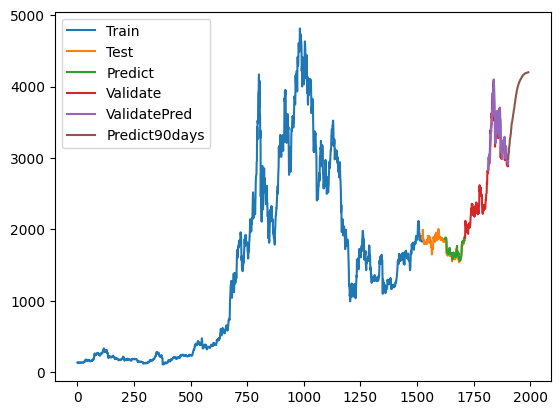

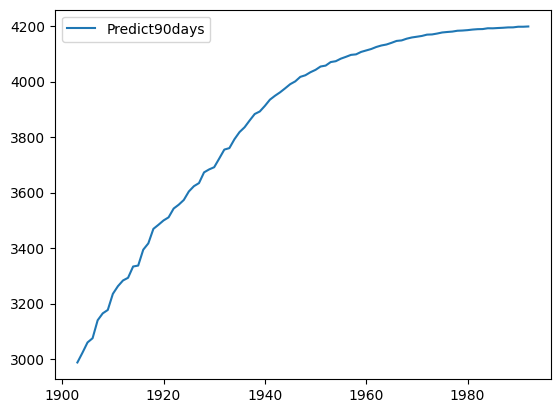

In [20]:
# 20.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict90days'])
plt.show()


# Dự đoán 90 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict90days'])
plt.show()

# **7:2:1**

In [21]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv("ETH.csv")
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
1,2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2,2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
3,2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
4,2019-03-05,127.792953,138.229981,126.735298,137.822388,137.822388,4764849990
...,...,...,...,...,...,...,...
1899,2024-05-12,2911.658203,2953.047363,2902.201904,2928.701904,2928.701904,5908941395
1900,2024-05-13,2928.813965,2994.869141,2865.134521,2949.359619,2949.359619,13352264795
1901,2024-05-14,2949.213135,2959.546631,2863.545898,2881.157959,2881.157959,12444516140
1902,2024-05-15,2881.224609,3041.602295,2864.735352,3037.056641,3037.056641,14666902956


In [22]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [23]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1332, 1)
Test shape: (380, 1)
Validate shape: (192, 1)


In [24]:
# 5. Convert an array of values into a dataset matrix
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [25]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [26]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [27]:
# 8. Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [28]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 2s 33ms/step - loss: 0.0094 - val_loss: 2.7297e-04
Epoch 2/100
20/20 [==============================] - 0s 22ms/step - loss: 0.0013 - val_loss: 2.7082e-04
Epoch 3/100
20/20 [==============================] - 0s 22ms/step - loss: 8.7507e-04 - val_loss: 1.5189e-04
Epoch 4/100
20/20 [==============================] - 0s 22ms/step - loss: 7.7002e-04 - val_loss: 2.1550e-04
Epoch 5/100
20/20 [==============================] - 0s 21ms/step - loss: 7.0578e-04 - val_loss: 2.7573e-04
Epoch 6/100
20/20 [==============================] - 0s 22ms/step - loss: 7.4860e-04 - val_loss: 4.5502e-04
Epoch 7/100
20/20 [==============================] - 0s 23ms/step - loss: 7.2398e-04 - val_loss: 1.4381e-04
Epoch 8/100
20/20 [==============================] - 0s 22ms/step - loss: 5.9751e-04 - val_loss: 2.6655e-04
Epoch 9/100
20/20 [==============================] - 1s 29ms/step - loss: 5.6564e-04 - val_loss: 1.8821e-04
Epoch 10/100
20/20 [================

In [29]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 8ms/step


In [30]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1) )
yval = scaler.inverse_transform(yval.reshape(-1,1) )

In [31]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 117.90709710838567
Testing RMSE: 40.77992198776744


In [32]:
# 13. Đánh giá độ chính xác thuật toán MAPE
valid_mape = np.mean(np.abs((y_pred_val - yval) / yval)) * 100
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 2.6498354601488243
Testing MAPE: 1.6786606890892972


In [33]:
# 14. Đánh giá độ chính xác thuật toán MAE
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 88.15559803760308
Testing MAE: 29.43141048821125


In [35]:
# 15. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=131
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.44927542 0.47270777 0.47521643 0.52568486 0.53366439 0.51342419
 0.52451382 0.50231726 0.51063859 0.52687334 0.51425567 0.50120646
 0.50598788 0.50175317 0.49841889 0.46798451 0.45306573 0.45155041
 0.4481788  0.45870516 0.45885113 0.45658009 0.46931128 0.4751455
 0.46196897 0.46649526 0.46739144 0.4648391  0.46345822 0.46544542
 0.48103901 0.4920022  0.49118573 0.50556612 0.50848278 0.50983178
 0.54185262 0.53846419 0.56733105 0.57721657 0.57281636 0.56919648
 0.588834   0.60256939 0.6174432  0.60826562 0.60840427 0.59790777
 0.61295149 0.63854157 0.65264274 0.66657997 0.69660977 0.68729693
 0.70710649 0.70434052 0.7190048  0.74866357 0.73261135 0.78881953
 0.80054378 0.80431139 0.8092796  0.8019998  0.84140269 0.82307402
 0.8286433  0.80241398 0.77095152 0.72578276 0.75121155 0.72474585
 0.6480962  0.72376913 0.71942968 0.68554606 0.68616416 0.71127167
 0.74025132 0.73953263 0.72094495 0.73395759 0.72343159 0.72261019
 0.75236934 0.72199032 0.67353848 0.68081434 0.6847

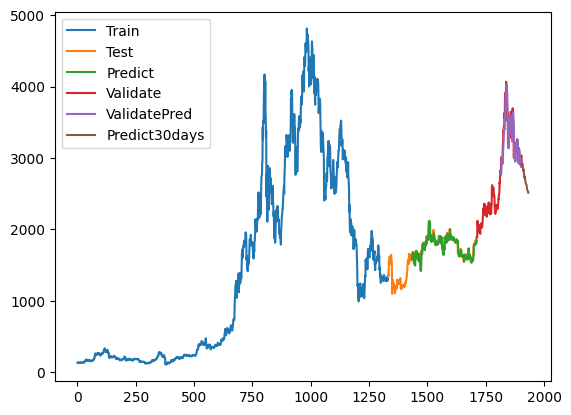

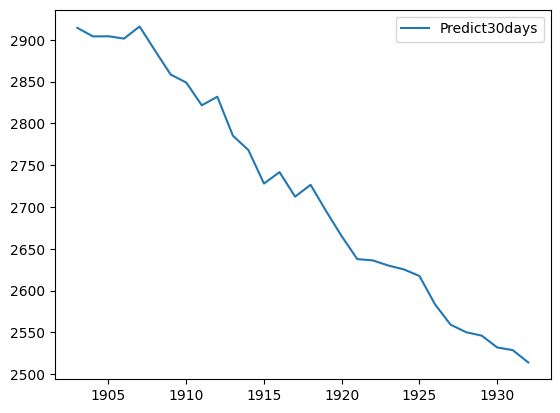

In [36]:
# 16.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()


# Dự đoán 30 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict30days'])
plt.show()

In [38]:
# 17. Dự báo 60 ngày tiếp theo
x_input=val_data[90:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=101
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.48103901 0.4920022  0.49118573 0.50556612 0.50848278 0.50983178
 0.54185262 0.53846419 0.56733105 0.57721657 0.57281636 0.56919648
 0.588834   0.60256939 0.6174432  0.60826562 0.60840427 0.59790777
 0.61295149 0.63854157 0.65264274 0.66657997 0.69660977 0.68729693
 0.70710649 0.70434052 0.7190048  0.74866357 0.73261135 0.78881953
 0.80054378 0.80431139 0.8092796  0.8019998  0.84140269 0.82307402
 0.8286433  0.80241398 0.77095152 0.72578276 0.75121155 0.72474585
 0.6480962  0.72376913 0.71942968 0.68554606 0.68616416 0.71127167
 0.74025132 0.73953263 0.72094495 0.73395759 0.72343159 0.72261019
 0.75236934 0.72199032 0.67353848 0.68081434 0.68477024 0.68239753
 0.6899055  0.7110288  0.76245899 0.72201867 0.73022326 0.72203664
 0.66626424 0.61561329 0.64795235 0.63618127 0.63263341 0.61132255
 0.62861498 0.62717947 0.64809812 0.6458991  0.65746217 0.66134595
 0.64430739 0.64786039 0.64225689 0.66820689 0.67046287 0.66039249
 0.61718439 0.60814422 0.61205443 0.63659425 0.639

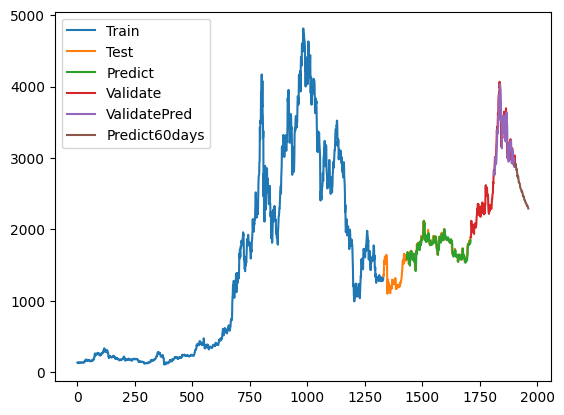

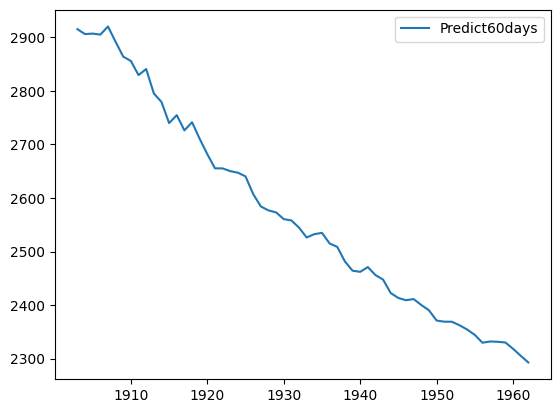

In [39]:
# 18.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict60days'])
plt.show()


# Dự đoán 60 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict60days'])
plt.show()

In [41]:
# 19. Dự báo 90 ngày tiếp theo
x_input=val_data[90:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=101
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.48103901 0.4920022  0.49118573 0.50556612 0.50848278 0.50983178
 0.54185262 0.53846419 0.56733105 0.57721657 0.57281636 0.56919648
 0.588834   0.60256939 0.6174432  0.60826562 0.60840427 0.59790777
 0.61295149 0.63854157 0.65264274 0.66657997 0.69660977 0.68729693
 0.70710649 0.70434052 0.7190048  0.74866357 0.73261135 0.78881953
 0.80054378 0.80431139 0.8092796  0.8019998  0.84140269 0.82307402
 0.8286433  0.80241398 0.77095152 0.72578276 0.75121155 0.72474585
 0.6480962  0.72376913 0.71942968 0.68554606 0.68616416 0.71127167
 0.74025132 0.73953263 0.72094495 0.73395759 0.72343159 0.72261019
 0.75236934 0.72199032 0.67353848 0.68081434 0.68477024 0.68239753
 0.6899055  0.7110288  0.76245899 0.72201867 0.73022326 0.72203664
 0.66626424 0.61561329 0.64795235 0.63618127 0.63263341 0.61132255
 0.62861498 0.62717947 0.64809812 0.6458991  0.65746217 0.66134595
 0.64430739 0.64786039 0.64225689 0.66820689 0.67046287 0.66039249
 0.61718439 0.60814422 0.61205443 0.63659425 0.639

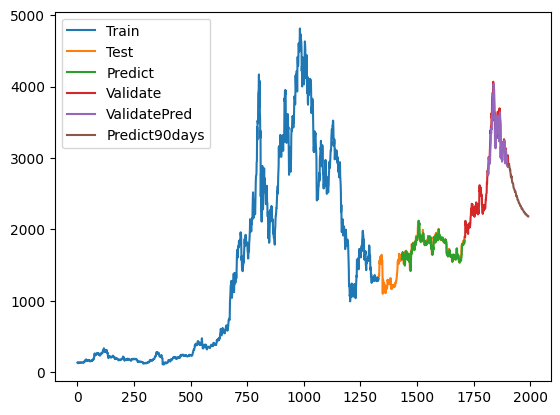

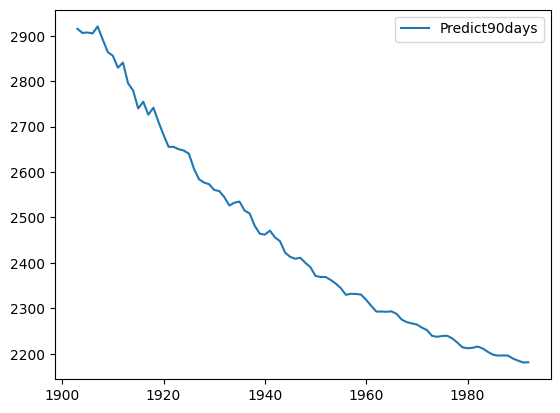

In [43]:
# 20.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict90days'])
plt.show()


# Dự đoán 90 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict90days'])
plt.show()

# **6:2:2**

In [44]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv("ETH.csv")
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
1,2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2,2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
3,2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
4,2019-03-05,127.792953,138.229981,126.735298,137.822388,137.822388,4764849990
...,...,...,...,...,...,...,...
1899,2024-05-12,2911.658203,2953.047363,2902.201904,2928.701904,2928.701904,5908941395
1900,2024-05-13,2928.813965,2994.869141,2865.134521,2949.359619,2949.359619,13352264795
1901,2024-05-14,2949.213135,2959.546631,2863.545898,2881.157959,2881.157959,12444516140
1902,2024-05-15,2881.224609,3041.602295,2864.735352,3037.056641,3037.056641,14666902956


In [45]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [46]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1142, 1)
Test shape: (380, 1)
Validate shape: (382, 1)


In [47]:
# 5. Convert an array of values into a dataset matrix
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [48]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [49]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [50]:
# 8. Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [51]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 2s 36ms/step - loss: 0.1133 - val_loss: 0.0024
Epoch 2/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 3/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 4/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 5/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 6/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 7/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0015 - val_loss: 7.5647e-04
Epoch 10/100
17/17 [==============================] - 1s 31ms/step - loss: 0.0016 - val_loss: 8.

In [52]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

9/9 [==============================] - 0s 8ms/step


In [53]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1) )
yval = scaler.inverse_transform(yval.reshape(-1,1) )

In [54]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 88.34360297654952
Testing RMSE: 78.29686585111072


In [55]:
# 13. Đánh giá độ chính xác thuật toán MAPE
valid_mape = np.mean(np.abs((y_pred_val - yval) / yval)) * 100
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 2.624353594644536
Testing MAPE: 3.8982822569791202


In [56]:
# 14. Đánh giá độ chính xác thuật toán MAE
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 64.30379344703626
Testing MAE: 58.129040135388664


In [58]:
# 15. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=321
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.38582733 0.38856528 0.3923834  0.3883941  0.38285424 0.36967722
 0.37434937 0.37327248 0.3727344  0.37646655 0.37599429 0.37467081
 0.40325706 0.38897126 0.38729508 0.38563929 0.3830793  0.38009154
 0.37826418 0.37868132 0.37891762 0.37313908 0.37830326 0.36996768
 0.37161394 0.37468063 0.3721702  0.37523044 0.37657555 0.37244386
 0.37127796 0.3746024  0.36764663 0.36680578 0.36522679 0.36677418
 0.36517344 0.36506215 0.37120246 0.37088133 0.37012749 0.3693556
 0.36973112 0.36768714 0.36873056 0.36506085 0.36053597 0.33485777
 0.32975546 0.33156911 0.33484045 0.33110056 0.32400142 0.33365409
 0.32954266 0.32805174 0.32664191 0.32902547 0.32795014 0.34438503
 0.33914976 0.32649991 0.32285256 0.32466777 0.3244747  0.32310015
 0.32394544 0.32365254 0.32691661 0.32447898 0.3242715  0.32037199
 0.3065059  0.31518226 0.31849166 0.32252993 0.32564937 0.32428412
 0.32166262 0.32473618 0.32605441 0.32166132 0.31345463 0.31536069
 0.31548607 0.31272005 0.3143088  0.31539236 0.3162

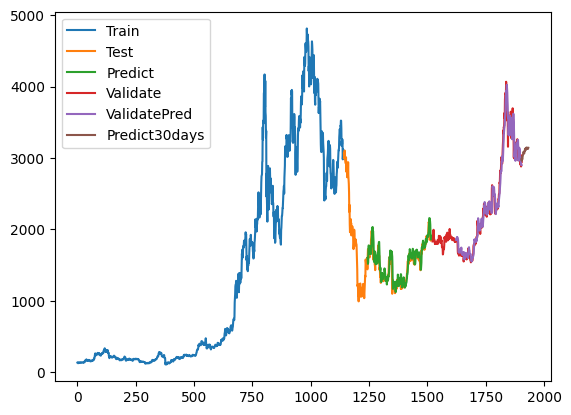

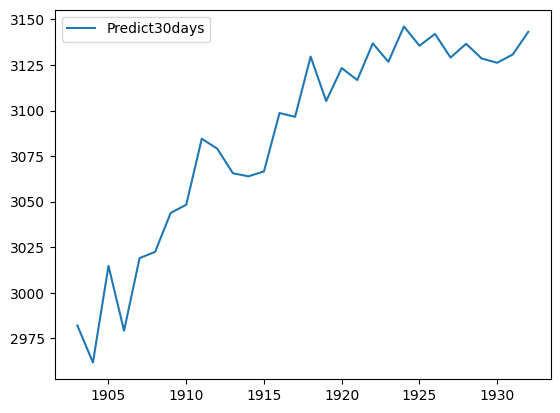

In [59]:
# 16.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()


# Dự đoán 30 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict30days'])
plt.show()

In [61]:
# 17. Dự báo 60 ngày tiếp theo
x_input=val_data[90:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=291
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.37127796 0.3746024  0.36764663 0.36680578 0.36522679 0.36677418
 0.36517344 0.36506215 0.37120246 0.37088133 0.37012749 0.3693556
 0.36973112 0.36768714 0.36873056 0.36506085 0.36053597 0.33485777
 0.32975546 0.33156911 0.33484045 0.33110056 0.32400142 0.33365409
 0.32954266 0.32805174 0.32664191 0.32902547 0.32795014 0.34438503
 0.33914976 0.32649991 0.32285256 0.32466777 0.3244747  0.32310015
 0.32394544 0.32365254 0.32691661 0.32447898 0.3242715  0.32037199
 0.3065059  0.31518226 0.31849166 0.32252993 0.32564937 0.32428412
 0.32166262 0.32473618 0.32605441 0.32166132 0.31345463 0.31536069
 0.31548607 0.31272005 0.3143088  0.31539236 0.31625889 0.3280406
 0.33124409 0.33192856 0.34525384 0.33032602 0.32884949 0.32696763
 0.31923353 0.32654083 0.32413301 0.32392826 0.3124974  0.3099251
 0.30961493 0.30394814 0.30660199 0.30727569 0.30787401 0.31690615
 0.30944154 0.30908215 0.30987065 0.31778515 0.32302553 0.33028399
 0.35196923 0.35602216 0.35665177 0.36019145 0.355087

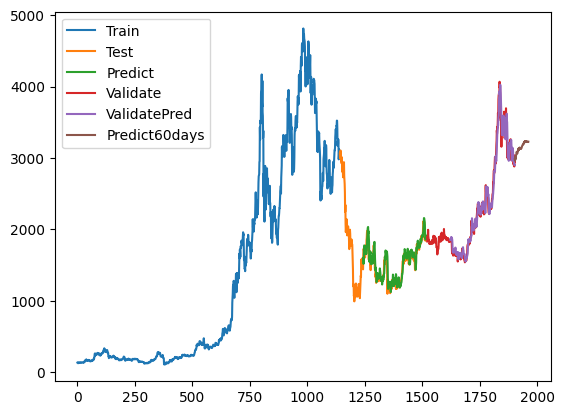

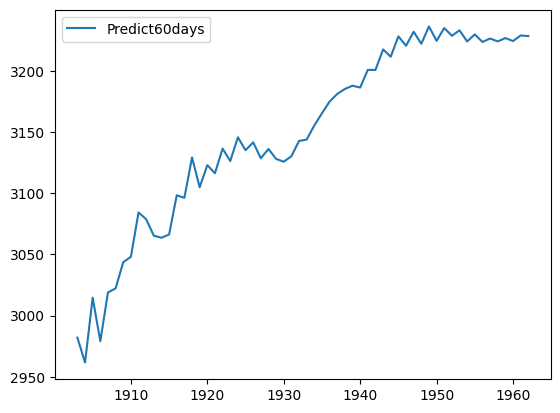

In [62]:
# 18.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict60days'])
plt.show()


# Dự đoán 60 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict60days'])
plt.show()

In [64]:
# 19. Dự báo 90 ngày tiếp theo
x_input=val_data[90:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=291
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.37127796 0.3746024  0.36764663 0.36680578 0.36522679 0.36677418
 0.36517344 0.36506215 0.37120246 0.37088133 0.37012749 0.3693556
 0.36973112 0.36768714 0.36873056 0.36506085 0.36053597 0.33485777
 0.32975546 0.33156911 0.33484045 0.33110056 0.32400142 0.33365409
 0.32954266 0.32805174 0.32664191 0.32902547 0.32795014 0.34438503
 0.33914976 0.32649991 0.32285256 0.32466777 0.3244747  0.32310015
 0.32394544 0.32365254 0.32691661 0.32447898 0.3242715  0.32037199
 0.3065059  0.31518226 0.31849166 0.32252993 0.32564937 0.32428412
 0.32166262 0.32473618 0.32605441 0.32166132 0.31345463 0.31536069
 0.31548607 0.31272005 0.3143088  0.31539236 0.31625889 0.3280406
 0.33124409 0.33192856 0.34525384 0.33032602 0.32884949 0.32696763
 0.31923353 0.32654083 0.32413301 0.32392826 0.3124974  0.3099251
 0.30961493 0.30394814 0.30660199 0.30727569 0.30787401 0.31690615
 0.30944154 0.30908215 0.30987065 0.31778515 0.32302553 0.33028399
 0.35196923 0.35602216 0.35665177 0.36019145 0.355087

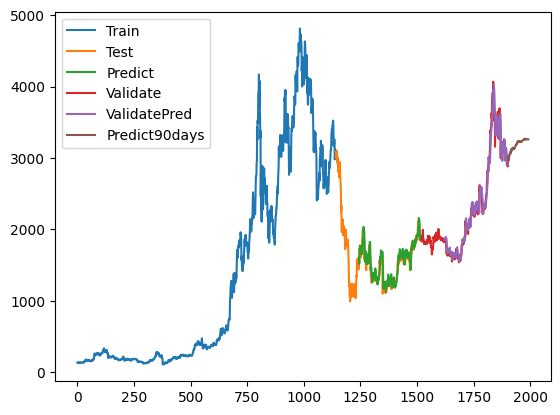

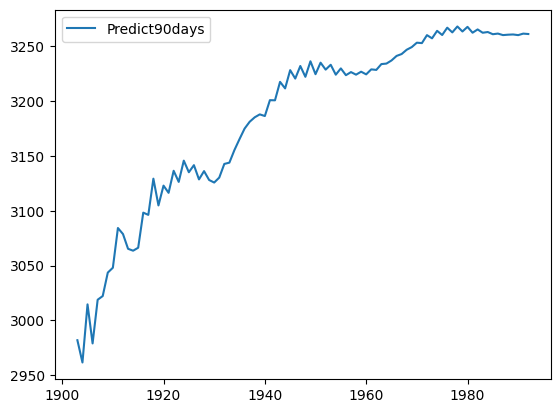

In [65]:
# 20.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict90days'])
plt.show()


# Dự đoán 90 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict90days'])
plt.show()